# Biweekly Report 6
## Nidhin, Harilal
# Fully Convolutional Networks for Semantic Segmentation

In this notebook, I work on the paper _Fully Convolutional Networks for Semantic Segmentation_ [(FCN)](arxiv.org/pdf/1411.4038.pdf).

Compared with classification and detection tasks which is what we have mostly covered, segmentation is a much more difficult task since it involves classifyingh the object class for each pixel within an image. This usually means a specialized architecture which could give dense image label predictions aka segmentation maps. The interesting aspect about this paper is that it adapts contemporary classification networks like VGG net, into fully convolutional networks and transfer their learned representations by fine-tuning to the segmentation task.  

In [1]:

import os
import time
import random
#import imageio
import imageio.v2 as imageio
import scipy.misc

import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from collections import namedtuple

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import utils
from torchvision.models.vgg import VGG
import pickle

## Table of Contents:

### - 1. CityScapes Dataset
    - Data Loader
    - Data Statistics
    - Data Visualization

### - 2.  Model Architecture
    - VGG Net
    - FCN
    - Hyperparameters

### - 3. Experiments
    - Training
    - Inference and Visualization
    - Animation

### - 4. Discussion

### - References


---
<br/>

**Reproducibility:** This notebook was ran on the following configuration:

- Python version used is 3.7
- All the cpu-intensive processing is done over `Intel Xeon(R)` chipset.
- All the cuda-processing (including training and inference) has been done over `NVIDIA RTX-3090`

# 1. CityScapes Dataset

CityScapes contains a diverse set of stereo video sequences recorded in street scenes from 50 different cities, with high quality pixel-level annotation. Since the main intention behind this dataset is assessing the performance of vision algorithms for major tasks of semantic urban scene understanding ie pixel-level semantic labeling, therefore I decide to use this dataset.

The data can be downloaded from the (site)[https://www.cityscapes-dataset.com/] 

Preprocessing CityScapes is a bit challenging, The following processing codes has been referred from these two repos:
- [https://github.com/mcordts/cityscapesScripts](https://github.com/mcordts/cityscapesScripts)
- [https://github.com/pochih/FCN-pytorch](https://github.com/pochih/FCN-pytorch)

In [2]:
root_dir  = "CityScapes/"

label_dir = os.path.join(root_dir, "gtFine")
train_dir = os.path.join(label_dir, "train")
val_dir   = os.path.join(label_dir, "val")
test_dir  = os.path.join(label_dir, "test")

# create dir for label index
label_idx_dir = os.path.join(root_dir, "Labeled_idx")
train_idx_dir = os.path.join(label_idx_dir, "train")
val_idx_dir   = os.path.join(label_idx_dir, "val")
test_idx_dir  = os.path.join(label_idx_dir, "test")
for dir in [train_idx_dir, val_idx_dir, test_idx_dir]:
    if not os.path.exists(dir):
        os.makedirs(dir)

train_file = os.path.join(root_dir, "train.csv")
val_file   = os.path.join(root_dir, "val.csv")
test_file  = os.path.join(root_dir, "test.csv")

color2index = {}

Label = namedtuple('Label', [
                   'name', 
                   'id', 
                   'trainId', 
                   'category', 
                   'categoryId', 
                   'hasInstances', 
                   'ignoreInEval', 
                   'color'])

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        1 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        2 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        3 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        4 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        5 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        6 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        7 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        8 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        9 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,       10 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       11 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       12 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       13 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       15 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       17 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       18 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       19 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

- **`parse_label -`**
After initiating the directories for our data, the next step is to parse the images and annotations to make them in a trainable format. For this, we iterate through each pixel over all the images and annotations, then construct a label matrix  to represent a segmentation map.

In [3]:
def parse_label():
    # change label to class index
    color2index[(0,0,0)] = 0  # add an void class 
    for obj in labels:
        if obj.ignoreInEval:
            continue
        idx   = obj.trainId
        label = obj.name
        color = obj.color
        color2index[color] = idx

    # parse train, val, test data    
    for label_dir, index_dir, csv_file in zip([train_dir, val_dir, test_dir], [train_idx_dir, val_idx_dir, test_idx_dir], [train_file, val_file, test_file]):
        f = open(csv_file, "w")
        f.write("img,label\n")
        for city in os.listdir(label_dir):   #cities categorized as folders
            city_dir = os.path.join(label_dir, city)
            city_idx_dir = os.path.join(index_dir, city)
            data_dir = city_dir.replace("gtFine", "leftImg8bit")
            if not os.path.exists(city_idx_dir):
                os.makedirs(city_idx_dir)
            for filename in tqdm(os.listdir(city_dir)): # each image
                if 'color' not in filename:
                    continue
                lab_name = os.path.join(city_idx_dir, filename)
                img_name = filename.split("gtFine")[0] + "leftImg8bit.png"
                img_name = os.path.join(data_dir, img_name)
                f.write("{},{}.npy\n".format(img_name, lab_name))

                if os.path.exists(lab_name + '.npy'):  # readable format
                    #print("Skip %s" % (filename))
                    continue
                #print("Parse %s" % (filename))
                img = os.path.join(city_dir, filename)
                img = imageio.imread(img, pilmode='RGB')
                height, weight, _ = img.shape
        
                idx_mat = np.zeros((height, weight))
                
                # iterating through pixels
                for h in range(height):
                    for w in range(weight):
                        color = tuple(img[h, w])
                        try:
                            index = color2index[color]
                            idx_mat[h, w] = index
                        except:
                            # no index, assign to void
                            idx_mat[h, w] = 19
                
                idx_mat = idx_mat.astype(np.uint8)
                np.save(lab_name, idx_mat)
                #print("Finish %s" % (filename))

parse_label()

  0%|          | 0/396 [00:00<?, ?it/s]

  0%|          | 0/488 [00:00<?, ?it/s]

  0%|          | 0/340 [00:00<?, ?it/s]

  0%|          | 0/1264 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 0/696 [00:00<?, ?it/s]

  0%|          | 0/884 [00:00<?, ?it/s]

  0%|          | 0/384 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/576 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/1460 [00:00<?, ?it/s]

  0%|          | 0/992 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/436 [00:00<?, ?it/s]

  0%|          | 0/380 [00:00<?, ?it/s]

  0%|          | 0/568 [00:00<?, ?it/s]

  0%|          | 0/1068 [00:00<?, ?it/s]

  0%|          | 0/696 [00:00<?, ?it/s]

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/2176 [00:00<?, ?it/s]

  0%|          | 0/184 [00:00<?, ?it/s]

  0%|          | 0/1192 [00:00<?, ?it/s]

  0%|          | 0/1592 [00:00<?, ?it/s]

  0%|          | 0/724 [00:00<?, ?it/s]

> Note: This may take several hours depending on the available compute

# Dataloader

Once all the preprocessing steps are complete, We'll need a data loader for iterating over the processed dataset in batches. 

**`CityScapesDataset`** does the following:
- In train phase, it augments images with random cropping, and horizontal flipping
- for each image it standardizes by reducing the mean and normalizes it
- create one hot-encodings for each label over all the pixels

In [4]:
h, w      = 1024, 2048
train_h   = int(h/2)  # 512
train_w   = int(w/2)  # 1024
val_h     = h  # 1024
val_w     = w  # 2048
num_class = 20

means = np.array([103.939, 116.779, 123.68]) / 255. # mean of three channels in the order of BGR


class CityScapesDataset(Dataset):

    def __init__(self, csv_file, phase, n_class=num_class, crop=False, flip_rate=0.):
        self.data = pd.read_csv(csv_file)
        self.means = means
        self.n_class = n_class

        self.flip_rate = flip_rate
        self.crop = crop
        
        if phase == 'train':
            self.crop = True
            self.flip_rate = 0.5
            self.new_h = train_h
            self.new_w = train_w

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #img_name   = self.data.ix[idx, 0]
        img_name   = self.data['img'][idx]
        
        img        = imageio.imread(img_name, pilmode='RGB')
        #label_name = self.data.ix[idx, 1]
        label_name = self.data['label'][idx]
        
        label      = np.load(label_name)

        if self.crop:
            h, w, _ = img.shape
            top   = random.randint(0, h - self.new_h)
            left  = random.randint(0, w - self.new_w)
            img   = img[top:top + self.new_h, left:left + self.new_w]
            label = label[top:top + self.new_h, left:left + self.new_w]

        if random.random() < self.flip_rate:
            img   = np.fliplr(img)
            label = np.fliplr(label)

        # reduce mean
        img = img[:, :, ::-1]  # switch to BGR
        img = np.transpose(img, (2, 0, 1)) / 255.
        img[0] -= self.means[0]
        img[1] -= self.means[1]
        img[2] -= self.means[2]

        # convert to tensor
        img = torch.from_numpy(img.copy()).float()
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.size()
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1

        sample = {'X': img, 'Y': target, 'l': label}
        return sample


In [5]:
batch_size = 6

train_data = CityScapesDataset(csv_file=train_file, phase='train')
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)

val_data = CityScapesDataset(csv_file=val_file, phase='val', flip_rate=0)
val_loader = DataLoader(val_data, batch_size=1, num_workers=8,pin_memory=True)

## Data statistics

In [6]:
batch = next(iter(train_loader))

In [7]:
print("Dataset Statistics\n")
print("Training images:", batch_size*len(train_loader))
print("Validation images:", 1*len(val_loader))
print("--"*5)
print("\nNo. of Semantic classes:", torch.max(batch['l'][0])+1)
print("Image Size:", batch['X'][0].shape)
print("Semantic label Size:", batch['Y'][0].shape)
print("--"*5)


Dataset Statistics

Training images: 2976
Validation images: 500
----------

No. of Semantic classes: tensor(20)
Image Size: torch.Size([3, 512, 1024])
Semantic label Size: torch.Size([20, 512, 1024])
----------


## Data Visualization


Sizes: torch.Size([6, 3, 512, 1024]) torch.Size([6, 20, 512, 1024])
torch.Size([6, 3, 512, 1024])
torch.Size([3, 1544, 2054])
(1544, 2054, 3)


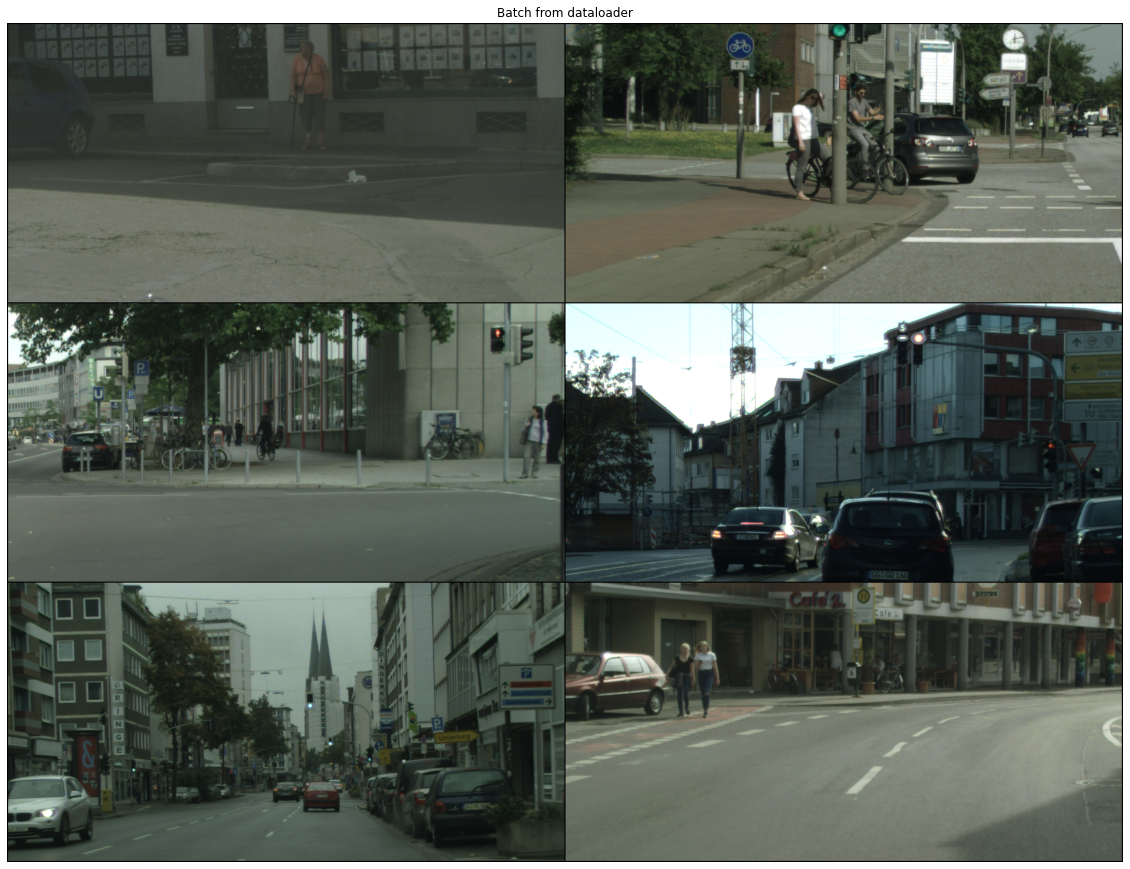

In [54]:
def show_batch(batch):
    img_batch = batch['X']
    img_batch[:,0,...].add_(means[0])
    img_batch[:,1,...].add_(means[1])
    img_batch[:,2,...].add_(means[2])
    batch_size = len(img_batch)
    
    plt.figure(figsize=[20, 20])
    grid = utils.make_grid(img_batch, nrow=2)
    aa = grid.numpy()[::-1].transpose((1, 2, 0))
    
    plt.imshow(grid.numpy()[::-1].transpose((1, 2, 0)))
    
    plt.title('Batch from dataloader')
    plt.axis('off')
    plt.ioff()
    plt.show()

batch = next(iter(train_loader))
print("Sizes:", batch['X'].size(), batch['Y'].size())
show_batch(batch)

The above shows the actual raw images. It can be observed to be a part of stereo video sequences recorded from a car. 

- **`show_labels -`** Below shows the corresponding sematnic segment labels for one such image. 

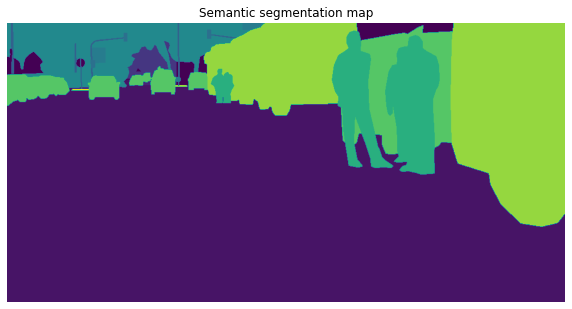


Showing Individual labels
torch.Size([3, 2098, 5180])


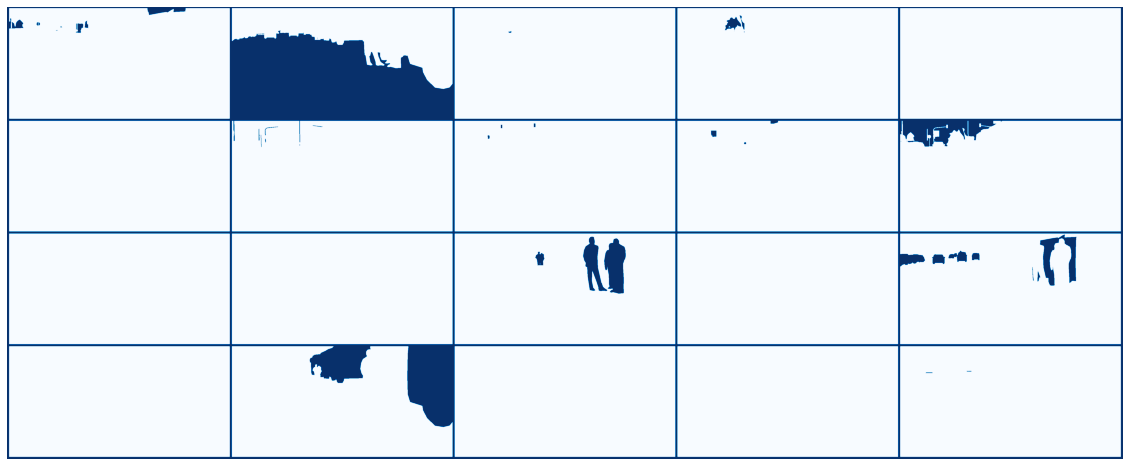

In [70]:
def show_labels(batch, individual=False, idx=0):
    plt.figure(figsize=[10,10])
    plt.imshow(batch['l'][idx,:,:])
    plt.title('Semantic segmentation map')
    plt.axis('off')
    plt.ioff()
    plt.show()
    
    if individual:
        print("\nShowing Individual labels")
        labels_batch = batch['Y'][idx][:,None,:,:]
        plt.figure(figsize=[20,20])
        grid = utils.make_grid(labels_batch, nrow=5,padding=10,pad_value=1)
        plt.imshow(grid.numpy()[0],cmap='Blues')
        
        plt.axis('off')
        plt.ioff()
        plt.show()
        
show_labels(batch, individual=True, idx=1)

.

# 2. Model Architecture

Since FCN adapts some contemporary classification networks into fully convolutional networks and transfer their learned representations by fine-tuning to the segmentation task. I focus that contemporary network to be VGG-16 net. 

## VGG-Net

Following shows the structure of VGG designed for classification purposes.

![VGG](https://viso.ai/wp-content/uploads/2021/10/vgg-neural-network-architecture.png)

> VGG Net: Image source - https://arxiv.org/abs/1409.1556v6  

Since PyTorch already has a pre-trained version of VGG-16, below I use publicly available codes to access the pretrained version of VGG-16.

In [8]:
# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

ranges = {
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
}
cfg = {
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
}

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

In [9]:
def test_vgg():
    batch_size, n_class, h, w = 10, 20, 160, 160
    # test output size
    vgg_model = VGGNet(requires_grad=True)
    inputt = torch.autograd.Variable(torch.randn(batch_size, 3, 224, 224))
    output = vgg_model(inputt)
    assert output['x5'].size() == torch.Size([batch_size, 512, 7, 7])
    

## FCN

The fully connected layers of classification networks like VGG-16 are first converted to fully convolutional layers and as shown in the figure below, it produces a class presence heatmap in low resolution. The idea is to upsample this using deconvolutions and each stage of upsampling is refined by fusing (simple addition) features from coarser but higher resolution feature maps from lower layers in the VGG 16. This fusion refines the segmentation using spatial information from different resolutions at different stages from the encoder.

![FCN1](https://www.meetshah.dev/images/blog/ss/fcn_1.png)

![FCN](https://www.meetshah.dev/images/blog/ss/fcn_2.png)
> Source: meetshah.dev

In [10]:
# cropped version from https://github.com/pochih/FCN-pytorch

class FCNs(nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net # VGG-net
        self.relu    = nn.ReLU(inplace=True)
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = nn.BatchNorm2d(256)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = nn.BatchNorm2d(128)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = nn.BatchNorm2d(32)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)
        x2 = output['x2']  # size=(N, 128, x.H/4,  x.W/4)
        x1 = output['x1']  # size=(N, 64, x.H/2,  x.W/2)

        score = self.bn1(self.relu(self.deconv1(x5)))     # size=(N, 512, x.H/16, x.W/16)
        score = score + x4                                # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.bn2(self.relu(self.deconv2(score)))  # size=(N, 256, x.H/8, x.W/8)
        score = score + x3                                # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = score + x2                                # element-wise add, size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = score + x1                                # element-wise add, size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score  # size=(N, n_class, x.H/1, x.W/1)
    
    

In [11]:
def test_FCNs():
    fcn_model = FCNs(pretrained_net=vgg_model, n_class=n_class)
    input = torch.autograd.Variable(torch.randn(batch_size, 3, h, w))
    output = fcn_model(input)
    assert output.size() == torch.Size([batch_size, n_class, h, w])
    

Once both VGG and FCN are available, it's time to load them on GPU.

In [12]:
vgg_model = VGGNet(requires_grad=True, remove_fc=True)
fcn_model = FCNs(pretrained_net=vgg_model, n_class=num_class)

# using gpu
vgg_model = vgg_model.cuda()
fcn_model = fcn_model.cuda()

In [13]:
from torchsummary import summary
summ = summary(fcn_model, (3,512,1024))

Layer (type:depth-idx)                   Output Shape              Param #
├─VGGNet: 1-1                            [[-1, 512, 16, 32]]       --
|    └─Sequential: 2                     []                        --
|    |    └─Conv2d: 3-1                  [-1, 64, 512, 1024]       1,792
|    |    └─ReLU: 3-2                    [-1, 64, 512, 1024]       --
|    |    └─Conv2d: 3-3                  [-1, 64, 512, 1024]       36,928
|    |    └─ReLU: 3-4                    [-1, 64, 512, 1024]       --
|    |    └─MaxPool2d: 3-5               [-1, 64, 256, 512]        --
|    |    └─Conv2d: 3-6                  [-1, 128, 256, 512]       73,856
|    |    └─ReLU: 3-7                    [-1, 128, 256, 512]       --
|    |    └─Conv2d: 3-8                  [-1, 128, 256, 512]       147,584
|    |    └─ReLU: 3-9                    [-1, 128, 256, 512]       --
|    |    └─MaxPool2d: 3-10              [-1, 128, 128, 256]       --
|    |    └─Conv2d: 3-11                 [-1, 256, 128, 256]       29

## Hyperparameters

In [14]:

lr = 1e-4          # learning rate
w_decay = 1e-5     # weight decay
step_size = 50     # step size for learning rate decay
gamma = 0.5        # learning rate decay factor 

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.RMSprop(fcn_model.parameters(), lr=lr, momentum=0, weight_decay=w_decay)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)  # decay LR by a factor of 0.5 every 50 epochs

# 3. Experiments

## Training

Below I have made a custom trainer class with the following functions:
- **`train -`** Iterate over epochs and performs series of forward and backward propagation to update model parameters.
- **`validate -`** Using the validation set, computes the average loss on predicted segment labels
- **`save_logs -`** Writes the train and validation losses to a file. 

In [15]:
SAVE_CKPT = 2
LOG_EPOCH = 1
    
class Trainer:
    def __init__(self):
        self.SAVE_CKPT = SAVE_CKPT
        self.LOG_EPOCH = LOG_EPOCH
                
        self.val_losses = []
        self.train_losses = []

        self.model_path = "checkpoints/"
        os.makedirs(self.model_path, exist_ok=True)
    
    
    def save_logs(self, filename):
        dic_ = {
            "train_loss":self.train_losses, 
            "val_loss"  :self.val_losses
        }
        
        with open(filename, 'wb') as f:
                pickle.dump(dic_, f)
        
    def validate(self):
        val_loss = 0
        fcn_model.eval()
        with torch.no_grad():
            for iter, batch in enumerate(val_loader):
                optimizer.zero_grad()

                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())
                
                outputs = fcn_model(inputs)
                loss = criterion(outputs, labels)
                val_loss+=loss.item()

        return val_loss/len(val_loader)
    
    def train(self, epochs):
        for epoch in range(epochs):
            fcn_model.train()

            ts = time.time()
            train_loss = 0
            for iter, batch in enumerate(train_loader):
                optimizer.zero_grad()

                inputs = Variable(batch['X'].cuda())
                labels = Variable(batch['Y'].cuda())

                outputs = fcn_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss+=loss.item()
                
            train_loss /= len(train_loader)
            self.train_losses.append(train_loss)
            val_loss = self.validate()
            self.val_losses.append(val_loss)
            
            print(f"Epoch {epoch}: Train loss: {train_loss:.6f}, Val loss: {val_loss:6f}, Time taken {time.time() - ts:.3f}")
            
            scheduler.step()
            
            if epoch%self.SAVE_CKPT==0:
                torch.save(fcn_model.state_dict(), self.model_path+f"ep_{epoch}.pth")
        
        self.save_logs("logs_.pkl")
        

In [16]:
epochs = 80

fcn_trainer = Trainer()
fcn_trainer.train(epochs)

Epoch 0: Train loss: 0.630007, Val loss: 0.573102, Time taken 215.859
Epoch 1: Train loss: 0.506546, Val loss: 0.436787, Time taken 215.186
Epoch 2: Train loss: 0.368321, Val loss: 0.306323, Time taken 213.426
Epoch 3: Train loss: 0.244045, Val loss: 0.200847, Time taken 214.644
Epoch 4: Train loss: 0.152885, Val loss: 0.126310, Time taken 214.146
Epoch 5: Train loss: 0.097355, Val loss: 0.080668, Time taken 215.639
Epoch 6: Train loss: 0.069101, Val loss: 0.062364, Time taken 215.305
Epoch 7: Train loss: 0.055414, Val loss: 0.056211, Time taken 216.739
Epoch 8: Train loss: 0.048956, Val loss: 0.047255, Time taken 215.745
Epoch 9: Train loss: 0.044983, Val loss: 0.048604, Time taken 216.311
Epoch 10: Train loss: 0.042946, Val loss: 0.045273, Time taken 218.277
Epoch 11: Train loss: 0.041569, Val loss: 0.043086, Time taken 216.912
Epoch 12: Train loss: 0.040189, Val loss: 0.044859, Time taken 218.352
Epoch 13: Train loss: 0.039638, Val loss: 0.041333, Time taken 214.769
Epoch 14: Train 

## Training Analysis

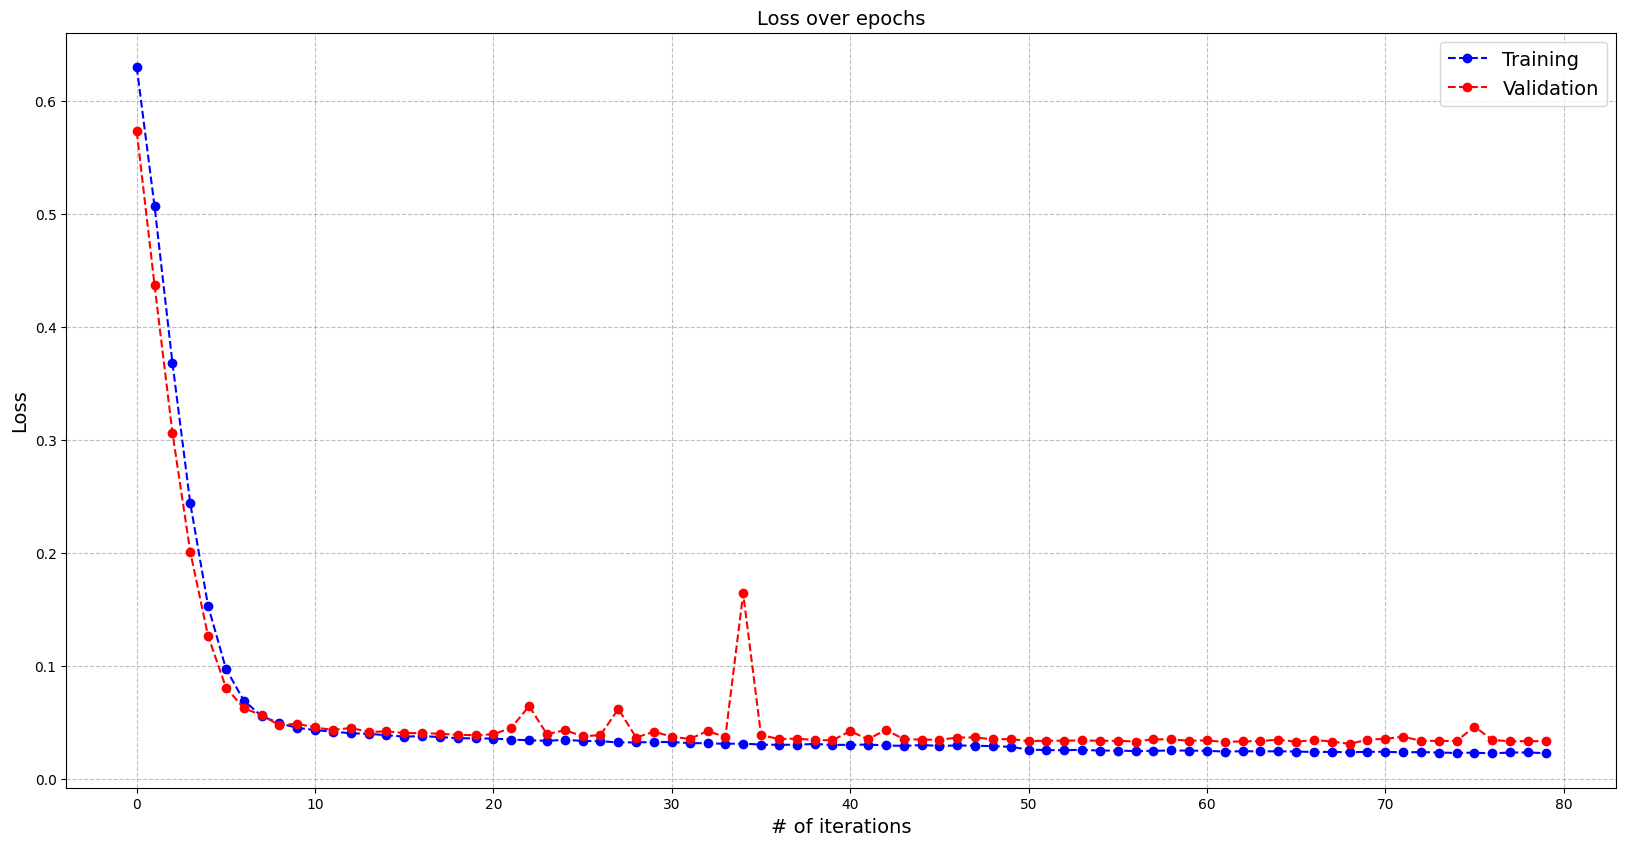

In [20]:
plt.figure(figsize=(20,10), dpi=100)
plt.plot(range(80),fcn_trainer.train_losses, color='b', marker='o', linestyle='dashed', label='Training')
plt.plot(range(80),fcn_trainer.val_losses, color='r', marker='o', linestyle='dashed', label='Validation')
plt.title("Loss over epochs", fontsize=14)
plt.xlabel("# of iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(ls='--', c='gray', alpha=0.5)
plt.show()

Both the training and validation losses seems to converging at similar rates which is good. The overall loss however seems to have converged around 20 iterations after which it improves slowly (could be due to learning rate deacay). Improvements in both the training and validation loss even adter 80 epochs indicates that model stil has the capacity to learn and overfitting is not happening.

## Inference and Visualization

- **`generate_preds -`** Generate a certain number of segmentation label predictions using the trained model on a given data iterator.

In [120]:
def generate_preds(data_loader, n):
    imgs = np.zeros((n,3,h,w))
    preds = np.zeros((n,h,w))
    gts = np.zeros((n,h,w))
    
    with torch.no_grad():
        for idx, batch in enumerate(data_loader):
            optimizer.zero_grad()
            
            inputs = Variable(batch['X'].cuda())
            labels = Variable(batch['Y'].cuda())
            outputs = fcn_model(inputs)
            
            
            out_ = np.squeeze(outputs.cpu().numpy())
            lab_ = np.squeeze(labels.cpu().numpy())

            imgs[idx,:,:,:] = np.squeeze(inputs.cpu().numpy())
            preds[idx,:,:] = np.argmax(out_, axis=0)
            gts[idx,:,:] = np.argmax(lab_, axis=0)
            
            if (idx+1)==n:
                return imgs, preds, gts
                
imgs, preds, gts = generate_preds(val_loader, n=6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


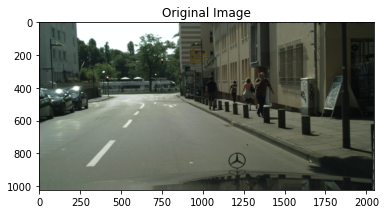

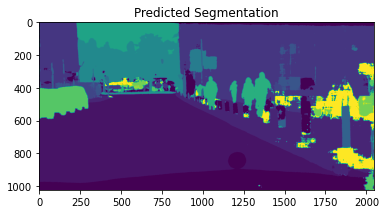

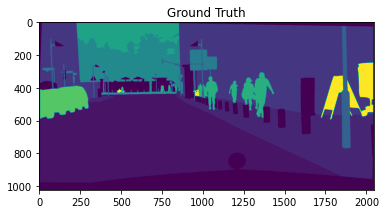

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------


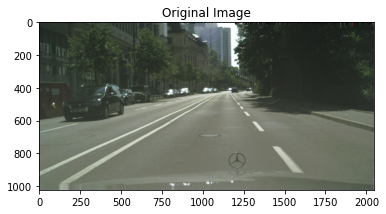

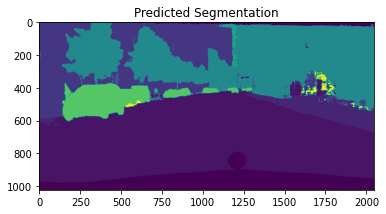

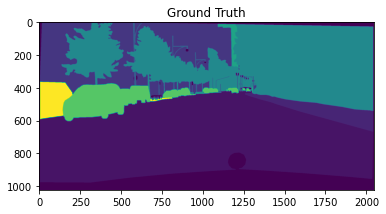

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------


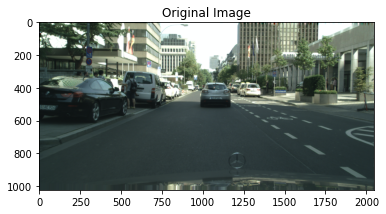

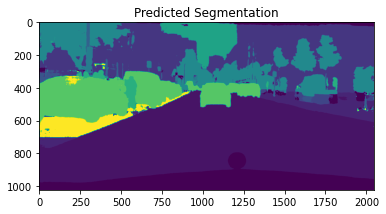

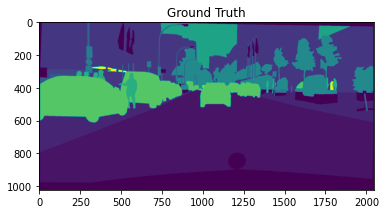

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------


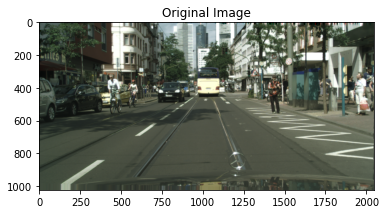

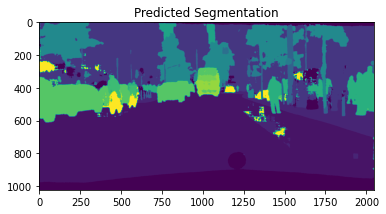

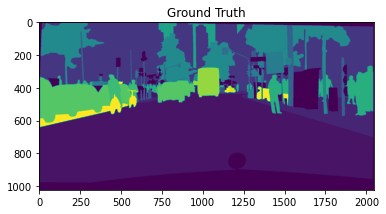

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------


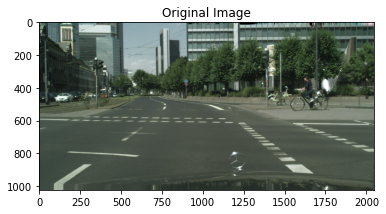

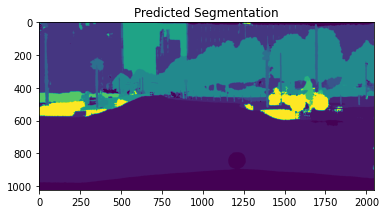

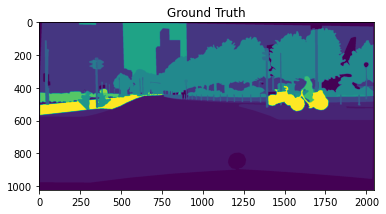

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


--------------------


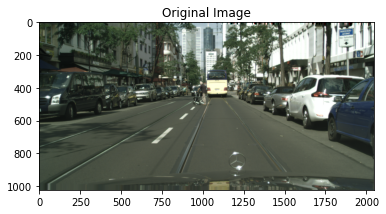

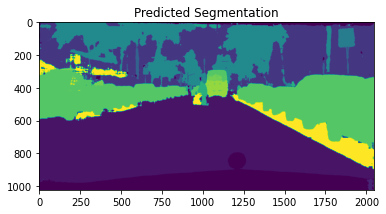

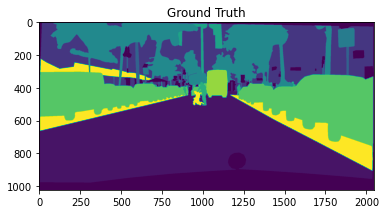

--------------------


In [121]:
for ix in range(6):
    imgs[ix,0,:,:]+=means[0]
    imgs[ix,1,:,:]+=means[1]
    imgs[ix,2,:,:]+=means[2]
    
    plt.imshow(imgs[ix][::-1].transpose(1,2,0))
    plt.title("Original Image")
    plt.show()
    
    plt.imshow(preds[ix])
    plt.title("Predicted Segmentation")
    plt.show()
    
    plt.imshow(gts[ix])
    plt.title("Ground Truth")
    plt.show()
    
    print("--"*10)

Bsed on the inference, we can say that the trainining was very succesfull. Considering how fast the model converges, it generates quite accurate segmentation maps. Some of the challengin scenarios forthe model to segment are as follows:
- **Trees -** The model is accurately able to segment the leafy portion of a tree, but it seems to be struggling while segmenting the narrow stem or branches. This also extends to road sign poles.
- **Human -** Well the model do segment a human, but has less precision around hands and legs.
- **Bikes -** An hard object to segment due to its narrow components, the particularly struggles in segmenting bike tires.
- **Light sources -** Since the images are recorded on a moving car, there's natural motion artifacts in the image. The model sometimes try to segment these light sources even when there's no object there.

### Animation

Lastly, I generate around 30 predictions. Then, using the input images, predicted and the ground truth segmentation maps, try to generate a GIF animation.

In [132]:
os.makedirs("Out/preds/")
os.makedirs("Out/imgs/")
os.makedirs("Out/gts/")

imgs, preds, gts = generate_preds(val_loader, n=30)

for ix in range(30):
    imgs[ix,0,:,:]+=means[0]
    imgs[ix,1,:,:]+=means[1]
    imgs[ix,2,:,:]+=means[2]

    plt.imshow(imgs[ix].transpose(1,2,0))
    plt.title("Original Image")
    plt.axis('off')
    plt.ioff()
    plt.savefig(f"Out/imgs/{ix}.png")
    
    plt.imshow(preds[ix])
    plt.title("Predicted Segmentation")
    plt.axis('off')
    plt.ioff()
    plt.savefig(f"Out/preds/{ix}.png")

    
    plt.imshow(gts[ix])
    plt.title("Ground Truth")
    plt.axis('off')
    plt.ioff()
    plt.savefig(f"Out/gts/{ix}.png")    
    print(ix, end='\r')

In [131]:
def generate_gif(DIR, savefile):
    images = []
    filenames = os.listdir(DIR)
    for filename in filenames:
        images.append(imageio.imread(DIR+filename))
    imageio.mimsave(savefile, images)
    print(savefile, "successfull!\n")
    
generate_gif(DIR="Out/preds/", savefile="Out/pred.gif")
generate_gif(DIR="Out/imgs/", savefile="Out/imgs2.gif")
generate_gif(DIR="Out/gts/", savefile="Out/gts.gif")

Out/pred.gif successfull!

Out/imgs2.gif successfull!

Out/gts.gif successfull!



<img src="Out/imgs2.gif" width="550" align="center">
<img src="Out/pred.gif" width="550" align="center">
<img src="Out/gts.gif" width="550" align="center">

# 4. Discussion

With the experiments on CityScapes which consists of ~3000 training images, FCN seems to have learned the task of segmentation quite quickly. The reason for the fast convergence and not needing thousands of training images could be attributed to the fact that FCN uses a pre-trained version of VGG-16. The pretrained net with its features has the capacity to generate good latent representations of the image. Using these representations and fine tuning it with additional fully convolutional layers make the FCN so robust. 

Even though FCN is quite good at overall segmentation, however it still lacks while generating boundaries around narrow objects. Personally, I am not a fan of deconvolutions in FCN as they could be deterimental for semantic segmentation as some of the original spatial information is lost and deconvolutions are also prone to artifacts (https://distill.pub/2016/deconv-checkerboard/). It would be interesting to see how more advanced methods like sub-pixel convolutions (https://arxiv.org/pdf/1707.02937) for upsampling the convolutional features could improve the overall segmentation capabilities of FCN. 

.
# References:

```
[1] Long, Jonathan, Evan Shelhamer, and Trevor Darrell. "Fully convolutional networks for semantic segmentation." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015.

[2] Github: mcordts/cityscapesScripts

[3] Github: pochih/FCN-pytorch

[4] meetshah.dev: semantic-segmentation-over-the-years

[5] Jeremy Jordan: An overview of semantic image segmentation.
```